<a href="https://colab.research.google.com/github/besomlu/stock_simulation/blob/main/1.systrader79_%EB%B0%9C%ED%91%9C%EC%A0%84%EB%9E%B5(IBS)_%EC%8B%9C%EB%AE%AC%EB%A0%88%EC%9D%B4%EC%85%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Colab에서 실행 가능한 형태의 파이썬 시뮬레이션 코드를 만들어줘.
아래 조건을 따라야 해:

0. 종목은 QQQ ETF이다.
1. 시작 원금은 10,000 USD이고, 매도에 따라 원금에 반영하여 투자한다.  
1. 거래 기간은 2000년 1월 1일 ~ 2024년 12월 31일이다.
   FinanceDataReader 사용하여 종가를 불러온다.
2. 나눔고딕 폰트를 설치하고, 폰트매니저에 설치된 폰트를 모두 등록한다.
   그리고 matplotlib에서 한글이 잘 보이도록 설정한다.
3. 지난 25일 동안의 고가에서 저가를 뺀 값의 이동평균을 계산한다.
4. IBS 지표를 계산한다.
   IBS = (종가-저가) / (고가 - 저가)
5. 하한선을 계산한다.
   하한선 = 지난 10일 동안의 고가 이동 평균 - 2.5x (1.항목의 이동평균)
6. 종가가 3. 하한선 아래이고 IBS가 0.3 미만일때 매수한다.
7. 종가가 어제 고가 보다 높으면 전량 매도한다.
8. 가격이 300일 이동 평균선 아래로 떨어지면 전량 매도한다.
9. 매수, 매도 시점마다 날짜, 수익률, 수익, 보유 기간, 누적 수익 등을 화면에 출력한다. 누적 수익은 매도 시점에만 업데이트한다.
10. 결과로 두 개의 그래프를 출력한다.
- 종가 + 매수/매도 표시 (레전드 중복 방지)
- 누적 수익 곡선

{'날짜': datetime.date(2001, 3, 13), '보유기간': 1, '수익률(%)': np.float64(5.08), '수익($)': np.float64(507.4), '누적 수익($)': np.float64(507.4)}
{'날짜': datetime.date(2001, 4, 4), '보유기간': 1, '수익률(%)': np.float64(-1.76), '수익($)': np.float64(-184.83), '누적 수익($)': np.float64(322.57)}
{'날짜': datetime.date(2001, 6, 15), '보유기간': 1, '수익률(%)': np.float64(0.83), '수익($)': np.float64(85.4), '누적 수익($)': np.float64(407.97)}
{'날짜': datetime.date(2001, 8, 20), '보유기간': 3, '수익률(%)': np.float64(1.38), '수익($)': np.float64(143.0), '누적 수익($)': np.float64(550.97)}
{'날짜': datetime.date(2001, 8, 22), '보유기간': 1, '수익률(%)': np.float64(2.73), '수익($)': np.float64(287.0), '누적 수익($)': np.float64(837.97)}
{'날짜': datetime.date(2001, 9, 7), '보유기간': 1, '수익률(%)': np.float64(-0.59), '수익($)': np.float64(-63.8), '누적 수익($)': np.float64(774.17)}
{'날짜': datetime.date(2001, 9, 18), '보유기간': 1, '수익률(%)': np.float64(-2.24), '수익($)': np.float64(-241.5), '누적 수익($)': np.float64(532.67)}
{'날짜': datetime.date(2001, 9, 21), '보유기간': 1, '수익률(%)': np.f

<ipython-input-10-90d119517fc6>:94: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cumulative_profit_series = cumulative_profit_series.ffill().fillna(method='ffill').fillna(0)


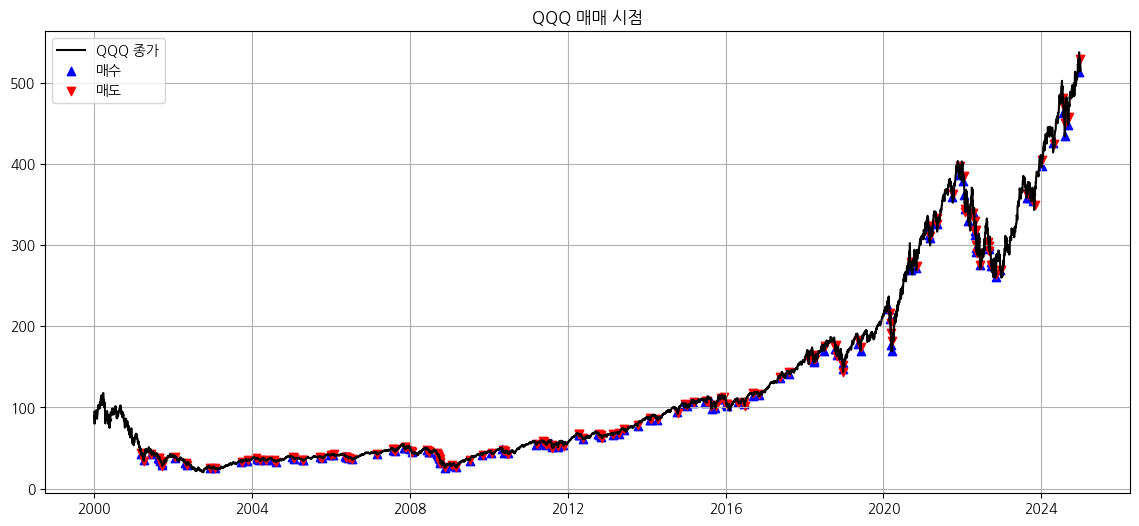

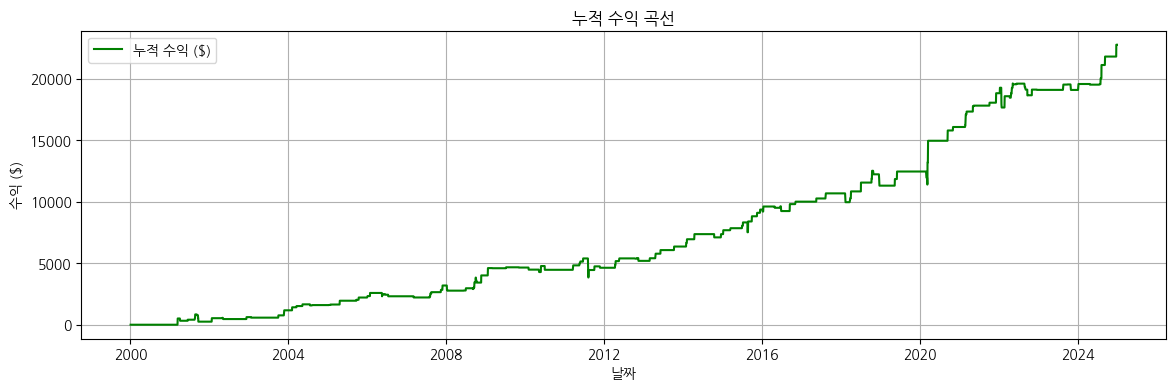

In [ ]:
# 1. 설치
!pip install finance-datareader
!apt-get -qq install fonts-nanum > /dev/null

# 2. 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 3. 라이브러리
import FinanceDataReader as fdr
import pandas as pd
import numpy as np

ticker = "QQQ"
# 4. 데이터 불러오기
start_date = '2000-01-01'
end_date = '2024-12-31'
qqq = fdr.DataReader(ticker, start=start_date, end=end_date)

# 5. 지표 계산
range_ma_25 = (qqq['High'] - qqq['Low']).rolling(window=25).mean()
ibs = (qqq['Close'] - qqq['Low']) / (qqq['High'] - qqq['Low'])
high_ma_10 = qqq['High'].rolling(window=10).mean()
lower_band = high_ma_10 - 2.5 * range_ma_25
ma_300 = qqq['Close'].rolling(window=300).mean()

# 6. 시뮬레이션 초기값
initial_cash = 10000
cash = initial_cash
shares = 0
entry_price = 0
entry_date = None
position = False
trade_logs = []
cumulative_profit_series = pd.Series(index=qqq.index, dtype=float)
signal = pd.Series(index=qqq.index, dtype=float)

# 7. 시뮬레이션 실행
for i in range(1, len(qqq)):
    date = qqq.index[i]
    prev_date = qqq.index[i - 1]

    if pd.isna(lower_band[date]) or pd.isna(ibs[date]) or pd.isna(ma_300[date]):
        continue

    close = qqq.loc[date, 'Close']
    prev_high = qqq.loc[prev_date, 'High']

    # 매수 조건
    if not position and close < lower_band[date] and ibs[date] < 0.3:
        shares = cash // close  # 최대 매수
        if shares > 0:
            cash -= shares * close
            entry_price = close
            entry_date = date
            position = True
            signal[date] = 1

    # 매도 조건
    elif position:
        sell = False
        if close > prev_high:
            sell = True
        elif close < ma_300[date]:
            sell = True

        if sell:
            proceeds = shares * close
            profit = proceeds - (shares * entry_price)
            return_pct = (close / entry_price - 1) * 100
            holding_days = (date - entry_date).days
            cash += proceeds
            position = False

            trade_logs.append({
                '날짜': date.date(),
                '보유기간': holding_days,
                '수익률(%)': round(return_pct, 2),
                '수익($)': round(profit, 2),
                '누적 수익($)': round(cash - initial_cash, 2)
            })
            print(trade_logs[-1])
            signal[date] = -1
            cumulative_profit_series[date] = cash - initial_cash
            shares = 0

# 마지막 수익 업데이트
cumulative_profit_series = cumulative_profit_series.ffill().fillna(method='ffill').fillna(0)

# 8. 그래프 1: 종가 + 매매 시점
plt.figure(figsize=(14, 6))
plt.plot(qqq['Close'], label=f'{ticker} 종가', color='black')
plt.scatter(signal[signal == 1].index, qqq.loc[signal == 1, 'Close'], label='매수', color='blue', marker='^')
plt.scatter(signal[signal == -1].index, qqq.loc[signal == -1, 'Close'], label='매도', color='red', marker='v')
plt.title(f'{ticker} 매매 시점')
plt.legend()
plt.grid(True)
plt.show()

# 9. 그래프 2: 누적 수익 곡선
plt.figure(figsize=(14, 4))
plt.plot(cumulative_profit_series, label='누적 수익 ($)', color='green')
plt.title('누적 수익 곡선')
plt.xlabel('날짜')
plt.ylabel('수익 ($)')
plt.grid(True)
plt.legend()
plt.show()
